# parse fit file and smooth gps
* cordinates are in semicircles (s)
* normal units for pos is degrees (d)
* usfull is also radians (r)

$d=s*180/2^31$

$r=d*pi/180$

* kalman filter can help smoothing track
    * does not work great - 
    * gps error is clearly not independent
    * potentially due to (kalman?) filter/ correction algorithm applied by the whatch
    * subsampling (eg at 30 seconds) improves performance
* which timepoints
    * fixed (e.g. every 30 seconds)
    * use gps quality
    * use magnetometer to detect turns / corrections of direction
    * use accelometer to detect turns / pauses ...
    * use button to mark turn
    



In [1]:

from fitparse import FitFile

from math import sqrt, pi, cos
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm, trange




#%matplotlib ipympl
R = 6371000 #earth radius [m]


In [118]:

#fitfile = FitFile('fit_files/2853423540.fit')#short swim
#fitfile = FitFile('fit_files/2871238195.fit')#longer swim two way
fitfile = FitFile('fit_files/1589443367.fit') #intermediate one way

In [119]:
def toDegree(s): 
    s=np.array(s)
    d=s*180/2**31
    return d


def toDeltaMeter(lat_d, lng_d):
    R = 6371000 #earth radius [m]
    delta_lat_d=np.diff(lat_d)
    delta_lng_d=np.diff(lng_d)
    delta_lat_m=delta_lat_d * R * pi / 180
    delta_lng_m=delta_lng_d * R * pi / 180 * np.cos(np.array(lat_d[:-1])*pi/180)
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))
    
    

In [120]:
data={}
# Get all data messages that are of type record
for i, record in enumerate(fitfile.get_messages('record')):
    #print("{}___".format(i))
    # Go through all the data entries in this record
    fields=set(['position_lat_deg', 'position_long_deg', 'delta_lat','delta_long', 'delta' ])
    for record_data in record:
        # Print the records name and value (and units if it has any)
        fields.add(record_data.name)
        if i==0:
            if record_data.units:
                print (" * {}: {} {}".format(record_data.name, record_data.value, record_data.units))
            else:
                print (" * {}: {}".format(record_data.name, record_data.value))
        if record_data.name not in data:
            data[record_data.name]=[np.nan] * i
        data[record_data.name].append(record_data.value)
    for missing in set(data.keys()).difference(fields):
        data[missing].append(np.nan)
    lat_deg=data['position_lat'][-1]*180/2 ** 31
    long_deg=data['position_long'][-1]*180/2 ** 31    
    if i==0:
        data['position_lat_deg']=[lat_deg]
        data['position_long_deg']=[long_deg]
        data['delta_lat']=[0]
        data['delta_long']=[0]
        data['delta']=[0]
    else:
        data['delta_lat'].append(R * (lat_deg-data['position_lat_deg'][-1])*pi/180)
        data['delta_long'].append(R * cos(lat_deg*pi/180) * (long_deg-data['position_long_deg'][-1])*pi/180)
        data['position_lat_deg'].append(lat_deg)
        data['position_long_deg'].append(long_deg)
        data['delta'].append(sqrt(data['delta_lat'][-1]**2 + data['delta_long'][-1]**2))
        


 * altitude: 14.0 m
 * distance: 0.0 m
 * enhanced_altitude: 14.0 m
 * enhanced_speed: 0.0 m/s
 * heart_rate: 96 bpm
 * position_lat: 340114472 semicircles
 * position_long: -193117425 semicircles
 * speed: 0.0 m/s
 * timestamp: 2017-02-24 14:25:19
 * unknown_88: 100


In [121]:
lat_d=toDegree(data['position_lat'])
lng_d=toDegree(data['position_long'])

test=toDeltaMeter(lat_d,lng_d)
test.head()

,delta_lat,delta_lng,dist
0,0.475333,0.515981,0.701554
1,-1.081149,8.763482,8.829920
2,0.214366,1.769077,1.782017
3,0.307568,1.678985,1.706924
4,0.083882,2.588094,2.589453


In [122]:
tab=pd.DataFrame.from_dict(data)
tab.head()

,altitude,delta,delta_lat,delta_long,distance,enhanced_altitude,enhanced_speed,heart_rate,position_lat,position_lat_deg,position_long,position_long_deg,speed,timestamp,unknown_88
0,14.0,0.000000,0.000000,0.000000,0.00,14.0,0.000,96,340114472.0,28.508066,-193117425.0,-16.186916,0.000,2017-02-24 14:25:19,100
1,14.2,0.701554,0.475333,0.515981,0.42,14.2,0.000,93,340114523.0,28.508070,-193117362.0,-16.186910,0.000,2017-02-24 14:25:21,100
2,-19.4,8.829921,-1.081149,8.763482,9.09,-19.4,1.670,95,340114407.0,28.508060,-193116292.0,-16.186821,1.670,2017-02-24 14:25:33,100
3,-17.4,1.782017,0.214366,1.769077,10.88,-17.4,1.633,95,340114430.0,28.508062,-193116076.0,-16.186802,1.633,2017-02-24 14:25:34,100
4,4.0,1.706924,0.307568,1.678985,12.59,4.0,1.745,95,340114463.0,28.508065,-193115871.0,-16.186785,1.745,2017-02-24 14:25:35,100


In [123]:

#tab.plot("delta", "speed")
#those are the same:
#x.plot("enhanced_speed", "speed")
#x.plot("enhanced_altitude", "altitude")
start_lat=data['position_lat_deg'][0]
start_lng=data['position_long_deg'][0]
end_lat=data['position_lat_deg'][-1]
end_lng=data['position_long_deg'][-1]

def get_dist(start_lat, start_lng, end_lat, end_lng, method="euclid"):
    total_delta_lat=R * (start_lat-end_lat)*pi/180
    total_delta_long=R * cos(start_lat)*(start_lng-end_lng)*pi/180
    if method == "euclid":
        return sqrt(total_delta_lat**2 + total_delta_long**2)
    elif method =="manhatten":
        return abs(total_delta_lat) + abs(total_delta_long)

dists=[get_dist(start_lat,start_lng, data['position_lat_deg'][i],data['position_long_deg'][i]) for i in range(len(data['position_long_deg']))]
i_turn=np.nanargmax(dists)
dist_back=get_dist(start_lat,start_lng, data['position_lat_deg'][i_turn],data['position_long_deg'][i_turn])+get_dist(data['position_lat_deg'][i_turn],data['position_long_deg'][i_turn], end_lat, end_lng)
[np.sum(tab.speed),np.sum(tab.delta), data['distance'][-1], get_dist(start_lat,start_lng,end_lat,end_lng), dist_back]



[1586.313, 1844.083695723119, 1315.68, 671.4566365740302, 716.4220701596291]

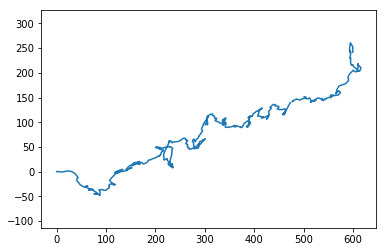

In [124]:
plt.axis('equal')
plt.plot(  np.cumsum(tab.delta_long), np.cumsum(tab.delta_lat))
plt.show()
tab.to_csv('fit_files/processed.csv')

![](fit_files/swimtrack_unfiltered.png)

# Kalman Filtering
http://www.cbcity.de/das-kalman-filter-einfach-erklaert-teil-2


In [125]:
kalman_lat=kalman_lng=kalman_gain=var=[]
#x_hat[k|k]=x_fit=(lat_fit,lat_speed_fit, lng_fit, lng_speed_fit) in meters 
#x_hat[k|k-1]=x_pred=(lat_pred,lat_speed_fit, lng_pred, lng_speed_fit) in meters        
#z=(lat_gps, lng_gps) in meters
#R=[[sigma_gps^2,0],[0,sigma_gps^2]]
#time step=dt
#F=[[1,dt,0,0][0,1,0,0][0,0,1,dt][0,0,0,1]]
#H=[[1,0,0,0][0,0,1,0]]
#sigma_lat_speed
#sigma_lng_speed
#Q=[[sigma_gps^2,sigma_gps*sigma_lat_speed,0,0],
#   [0,sigma_lat_speed^2,0,0],
#   [0,0,sigma_lat_speed*sigma_gps,sigma_gps^2],
#   [0,0,0,sigma_lat_speed^2]]
#y_pred=z-Hx Innovation covar/pre fit residual
#y_fit=z-Hx_fit Innovation covar/post fit residual
col_names=["dt","lat_gps", "lng_gps", "speed_gps", "lat_fit", "lng_fit", "speed_fit", "estimated accuracy","kalman gain" ]
track=pd.DataFrame(columns=col_names)


for row in tab[1::30].itertuples():
    i=row.Index
    gps_lat=toDegree(row.position_lat)
    gps_lng=toDegree(row.position_long)
    if not np.isnan(gps_lat) and not np.isnan(gps_lng):

        if track.shape[0] == 0:
            #initialize:        
            z_lat=0
            z_lng=0
            lat_fit=0
            lng_fit=0
            lat_speed_fit=0
            lng_speed_fit=0
            sigma_gps=3 #estimated gps accuracy (= standard deviation in meter?)
            z_dist=0
            dist_fit=0
            dt=1
            p_fit=2**2
            k=1
        else:
            dt= (row.timestamp - prev_time).total_seconds() 

            #gps position in meter
            delta_z=toDeltaMeter([gps_lat_prev,gps_lat],[gps_lng_prev,gps_lng])
            z_dist=delta_z.dist[0]
            z_lat+=delta_z.delta_lat[0]
            z_lng+=delta_z.delta_lng[0]

            #estimated accuracy
            sigma_gps=min(3,z_dist/dt)*2
            r=sigma_gps**2 #R
            q_pos=.01*dt**2       #may depend on swimming phase? e.g. turn
            #q_pos=5**2
            #q_speed=(2*dt)**2

            #predict position: may depend on swimming phase? e.g. turn
            lat_pred=lat_fit+lat_speed_fit*dt
            lng_pred=lng_fit+lng_speed_fit*dt
            #prediction error covariance (P_k|k-1): 
            p_pred=p_fit+q_pos
            #p_speed_pred=p_speed_fit+q_speed

            #innovation y (pre-fit residuals)
            y_lat=z_lat-lat_pred
            y_lng=z_lng-lng_pred
            #innovation covariance S
            s=r+p_pred
            #kalman gain= prediction error covariance/innovation covariance
            k = p_pred/s
            #apply k
            lat_fit=lat_pred+y_lat*k
            lng_fit=lng_pred+y_lng*k
            lat_speed_fit=(lat_fit-lat_fit_prev)/dt
            lng_speed_fit=(lng_fit-lng_fit_prev)/dt        
            p_fit=(1-k)*p_pred+k*r
            dist_fit=sqrt((lat_speed_fit*dt)**2+(lng_speed_fit*dt)**2)

        df=pd.DataFrame([[dt, z_lat, z_lng,z_dist/dt, lat_fit, lng_fit, dist_fit/dt, p_fit,k]],columns=col_names)
        track=track.append(df, ignore_index=True)
        lat_fit_prev=lat_fit
        lng_fit_prev=lng_fit    
        gps_lat_prev=gps_lat
        gps_lng_prev=gps_lng       
        prev_time=row.timestamp

        
    track.to_csv('fit_files/kalman.csv')


/pkg/python-3.6.4-2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


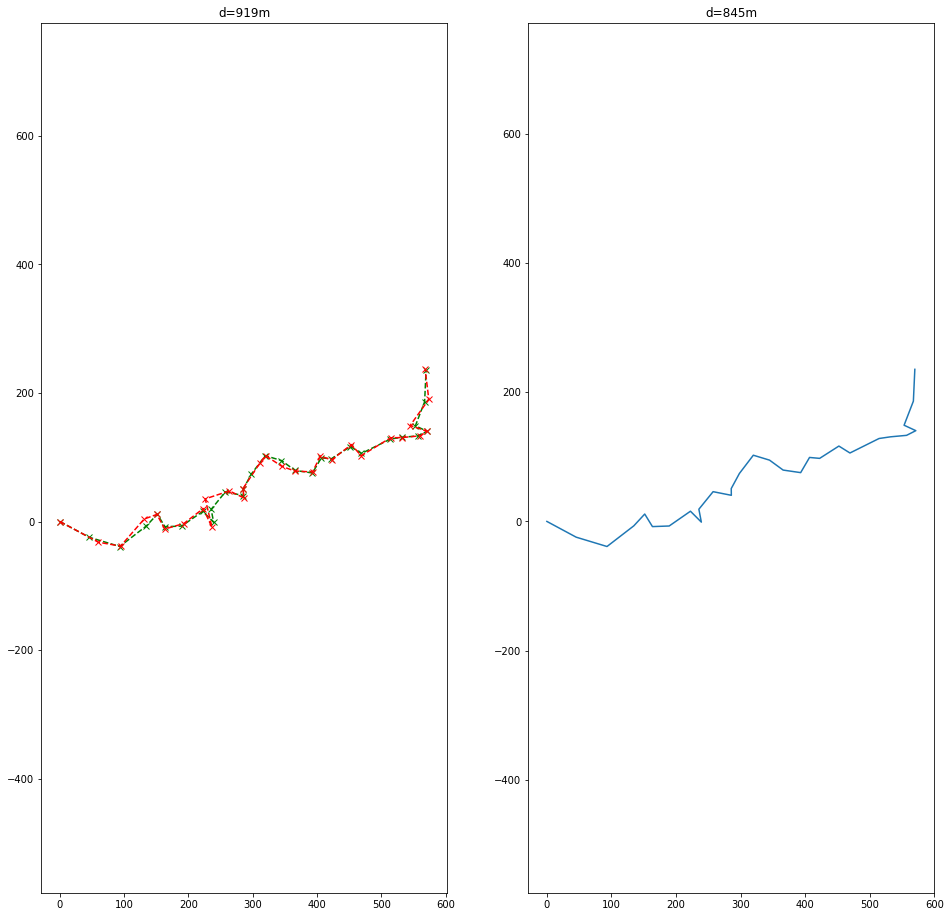

In [127]:
plt.axis('equal')
#import gtk

lim=(50,0,-10,200)

step=1

ax = plt.subplot(1, 2, 1)
ax.plot(track.lng_fit[0::step], track.lat_fit[0::step], "gx--")
ax.plot(track.lng_gps[0::step], track.lat_gps[0::step], "rx--")

dist=(track.lng_gps[0::step].diff().pow(2)+track.lat_gps[0::step].diff().pow(2)).pow(1/2).sum()
ax.set_title("d={}m".format(round(dist)))
#ax.axis(lim)
#ax.figure.set_size_inches(4,2)
ax.axis('equal')
ax = plt.subplot(1, 2, 2)
ax.plot(track.lng_fit[0::step], track.lat_fit[0::step])
dist=(track.lng_fit[0::step].diff().pow(2)+track.lat_fit[0::step].diff().pow(2)).pow(1/2).sum()
ax.set_title("d={}m".format(round(dist)))
ax = plt.subplot(1, 2, 2)
#ax.axis(lim)
ax.figure.set_size_inches(16,16)
ax.axis('equal')

plt.savefig('fit_files/filter.pdf')

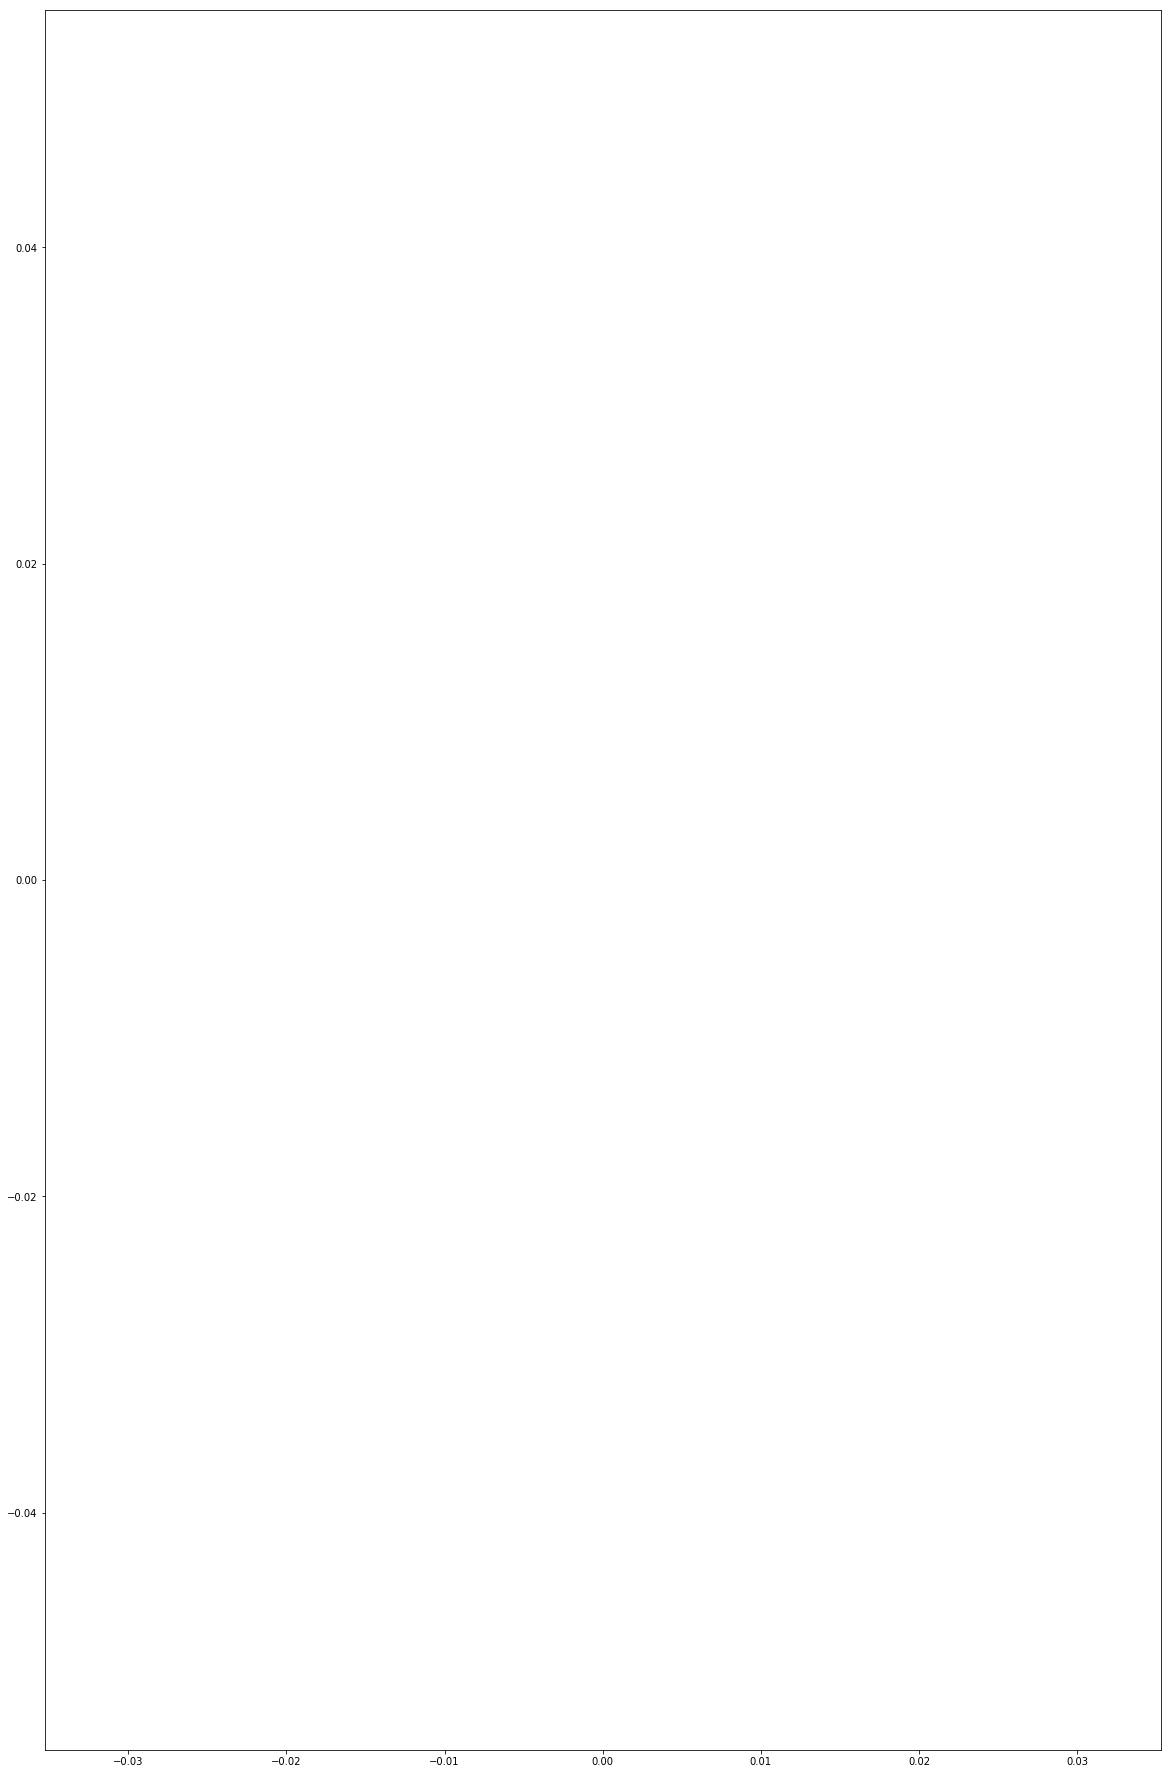

In [112]:
# red dashes, blue squares and green triangles
#plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
fig=plt.subplot(1,1,1)
fig.plot(track.lng_fit[100:200], track.lat_fit[100:200], 'bs',track.lng_gps[100:200], track.lat_gps[100:200], "g^" )
fig.figure.set_size_inches(20,32)
fig.axis('equal')

plt.savefig('fit_files/filter_ol.pdf')


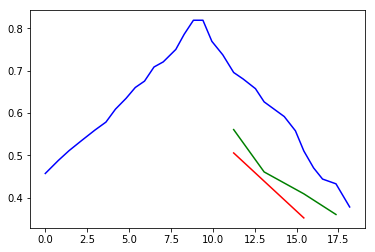

In [138]:
def runningMean(x, N):
    return np.convolve(x, np.ones((N,))/N, 'same')
time=np.cumsum(track.dt)/60
N=min(100,time.shape[0])
speed1=runningMean(track.speed_gps, N)
plt.plot(time, speed1,"b")

col=['g', 'r', 'c', 'm', 'y', 'k', 'tab:orange']
for i,step in enumerate([3,6,10,30,60,120,240]):
    speed=(track.lng_gps[0::step].diff().pow(2)+track.lat_gps[0::step].diff().pow(2)).pow(1/2)/(time[0::step].diff()*60)
    N=min(round(240/step)*2+1, speed.shape[0])
    speed=runningMean(speed, N)
    plt.plot(time[0::step],speed,col[i])
    

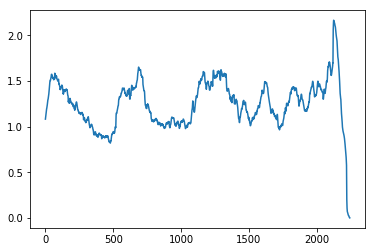

In [39]:
plt.plot(runningMeanFast(track.speed_fit, 100))

(0, 7, 0, 7)

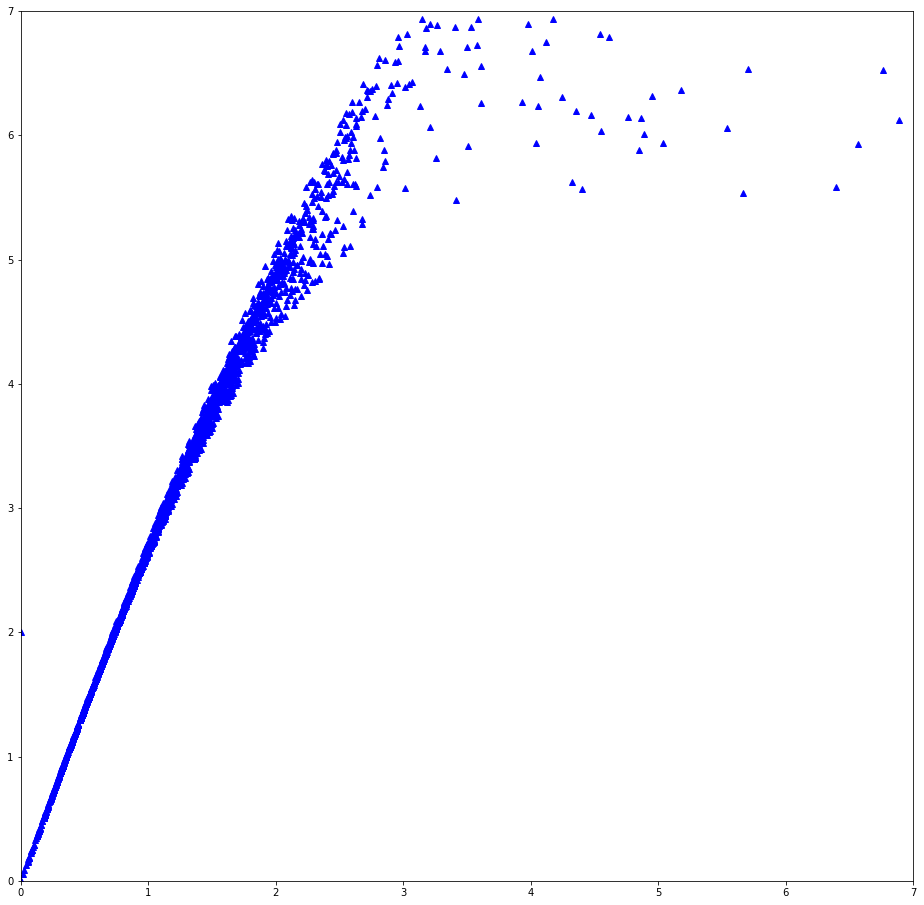

In [61]:
fig=plt.subplot(1,1,1)
fig.plot(track.speed_gps, [sqrt(track["estimated accuracy"][i]) for i in range(track.shape[0])], "b^")
fig.figure.set_size_inches(16,16)
fig.axis((0,7,0,7))
